# Wine Spirit Project

In [1]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import csv
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

### Create Database 
1.create a database and connect to it

2.extract a set of customer supplied xlsx files

3.they saved in sql database

In [2]:
connection = sql.connect('winespiritprojet.db')
curs = connection.cursor()

In [3]:
ERP_df = pd.read_excel(r'E:\projet_wine_spirit\erp.xlsx') 
liaison_df = pd.read_excel(r'E:\projet_wine_spirit\liaison.xlsx')
web_df = pd.read_excel(r'E:\projet_wine_spirit\web.xlsx')

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
ERP_df.to_sql('winespiritprojet', connection, if_exists = 'replace', index = False)
liaison_df.to_sql('winespiritprojet', connection, if_exists = 'replace', index = False)
web_df.to_sql('winespiritprojet', connection, if_exists = 'replace', index = False)

In [5]:
connection.close()

# Analysis

we will prepare the data in order to achieve what is requested by the customer see:

-> the calculation of turnover by product and the total turnover achieved.

-> a graphic presentation of the outliers concerning the prices of the products.

-> detect any input errors.

for that we will proceed to a data cleaning, and join files

### 1.Exploratory data analysis

###### A. le fichier Web

In [6]:
web_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             1430 non-null   object        
 13  pos

-> we see that there are several completely empty columns, an inconsistency of the data "post_content", "post_password", "post_content_filtred", "tax_class"


In [7]:
web_df_cln = web_df.drop(columns=['post_content','post_password','post_content_filtered','tax_class'])

In [8]:
web_df_cln.describe()

,virtual,downloadable,rating_count,average_rating,total_sales,post_author,post_parent,menu_order,comment_count
count,1513.0,1513.0,1513.0,1430.0,1430.000000,1430.000000,1430.0,1430.0,1430.0
mean,0.0,0.0,0.0,0.0,4.006993,1.998601,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,8.510559,0.037385,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.000000,2.000000,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,1.000000,2.000000,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,4.000000,2.000000,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,96.000000,2.000000,0.0,0.0,0.0


-> we see that several columns have only zero values (min, max, mean, std), so we will discard them  

"virtual","downloadable","rating_count","average_rating","post_parent","menu_order","comment_count"



In [9]:
web_df_cln = web_df_cln.drop(columns=['virtual','downloadable','rating_count','average_rating','post_parent','menu_order','comment_count'])

In [10]:
web_df_cln

,sku,total_sales,tax_status,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,post_modified,post_modified_gmt,guid,post_type,post_mime_type
0,bon-cadeau-25-euros,10.0,taxable,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
1,15298,6.0,taxable,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
2,15296,0.0,taxable,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
3,15300,0.0,taxable,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
4,19814,3.0,taxable,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,https://www.wine-spirit.fr/?post_type=product&...,product,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,16135,5.0,NaN,2.0,2020-04-25 13:22:38,2020-04-25 11:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,NaN,publish,closed,closed,mouthes-le-bihan-aime-chai-2015,2020-08-26 17:35:03,2020-08-26 15:35:03,https://www.wine-spirit.fr/wp-content/uploads/...,attachment,image/jpeg
1509,15891,0.0,NaN,2.0,2020-05-02 14:53:40,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,NaN,publish,closed,closed,camin-larredya-jurancon-sec-la-virada-2018,2020-08-26 17:35:02,2020-08-26 15:35:02,https://www.wine-spirit.fr/wp-content/uploads/...,attachment,image/jpeg
1510,15887,0.0,NaN,2.0,2020-05-02 15:00:54,2020-05-02 13:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,NaN,publish,closed,closed,jamet-cote-rotie-fructus-voluptas-2018,2020-08-14 18:15:03,2020-08-14 16:15:03,https://www.wine-spirit.fr/wp-content/uploads/...,attachment,image/jpeg
1511,13127-1,0.0,NaN,2.0,2020-06-09 15:42:04,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,NaN,publish,closed,closed,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 17:09:06,2020-07-20 15:09:06,https://www.wine-spirit.fr/wp-content/uploads/...,attachment,image/jpeg


In [11]:
web_df_cln['post_mime_type'].value_counts()

image/jpeg    714
Name: post_mime_type, dtype: int64

In [12]:
web_df_cln['ping_status'].value_counts()

closed    1430
Name: ping_status, dtype: int64

In [13]:
web_df_cln['comment_status'].value_counts()

closed    1430
Name: comment_status, dtype: int64

In [14]:
web_df_cln['post_status'].value_counts()

publish    1430
Name: post_status, dtype: int64

In [15]:
web_df_cln['tax_status'].value_counts()

taxable    716
Name: tax_status, dtype: int64

-> we see that some columns contain a single value and which are not relevant for our objective, so we will discard them

-> we will keep a single column for the date of the post 'post_modified_gmt'

In [16]:
web_df_cln = web_df_cln.drop(columns = ['post_mime_type','post_modified','tax_status','post_status','comment_status','ping_status','post_date'])

In [17]:
# I check for duplicates concerning the target variable "sku"
web_df_cln.sku.duplicated().sum()

798

-> we find duplicates of the target variable and we decide to remove them

In [18]:
# remove duplicates from the "sku" column
web_df_cln.drop_duplicates(subset = ['sku'], ignore_index = True, inplace = True)

In [19]:
web_df_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sku                714 non-null    object        
 1   total_sales        714 non-null    float64       
 2   post_author        714 non-null    float64       
 3   post_date_gmt      714 non-null    datetime64[ns]
 4   post_title         714 non-null    object        
 5   post_excerpt       714 non-null    object        
 6   post_name          714 non-null    object        
 7   post_modified_gmt  714 non-null    datetime64[ns]
 8   guid               714 non-null    object        
 9   post_type          714 non-null    object        
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 56.0+ KB


-> we find a table of data consistent with each other

###### B.le fichier liaison

In [20]:
liaison_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


-> we see that "id_web" contains less value than "id_product"

In [21]:
liaison_df.id_web.duplicated().sum()

90

In [22]:
liaison_df.product_id.duplicated().sum()

0

-> we find duplicates of the target variable and we decide to remove them

In [23]:
liaison_df_cln = liaison_df.dropna().reset_index(drop = True)

In [24]:
liaison_df_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  734 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


-> we find a table of data consistent with each other

###### C.le fichier ERP

In [25]:
ERP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB


In [26]:
ERP_df.product_id.duplicated().sum()

0

-> we find a table of data consistent with each other

-> no duplicates 

### 2.merging of different files

*  First merge between "web_df_cln" and "liaison_df_cln" on 'left'

In [27]:
fusion = web_df_cln.merge(liaison_df_cln, how='left', left_on = 'sku', right_on='id_web' )

*  Second merge between "ERP_df" and "fusion" on 'left'

In [28]:
fusion_all = ERP_df.merge(fusion, how='left', left_on = 'product_id', right_on='product_id' )

In [29]:
fusion_all

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_name,post_modified_gmt,guid,post_type,id_web
0,3847,1,24.2,0,outofstock,15298,6.0,2.0,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product,15298
1,3849,1,34.3,0,outofstock,15296,0.0,2.0,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 08:00:17,https://www.wine-spirit.fr/?post_type=product&...,product,15296
2,3850,1,20.8,0,outofstock,15300,0.0,2.0,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product,15300
3,4032,1,14.1,0,outofstock,19814,3.0,2.0,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,pierre-jean-villa-igp-gamine-2018,2020-01-04 15:36:01,https://www.wine-spirit.fr/?post_type=product&...,product,19814
4,4039,1,46.0,0,outofstock,19815,0.0,2.0,2018-02-12 08:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017,Le côte rôtie Carmina monte en puissance mais ...,pierre-jean-villa-cote-rotie-carmina-2017,2020-01-04 15:36:10,https://www.wine-spirit.fr/?post_type=product&...,product,19815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
821,7204,0,45.0,9,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
822,7247,1,54.8,23,instock,13127-1,0.0,2.0,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",clos-du-mont-olivet-chateauneuf-du-pape-2007-2,2020-07-20 15:09:06,https://www.wine-spirit.fr/?post_type=product&...,product,13127-1
823,7329,0,26.5,14,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


### 3.cleaning and choice relevant values

-> after the merger we notice that there are redundant columns we decide to delete them

In [30]:
fusion_all.drop(columns=['id_web','post_name'])

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_modified_gmt,guid,post_type
0,3847,1,24.2,0,outofstock,15298,6.0,2.0,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product
1,3849,1,34.3,0,outofstock,15296,0.0,2.0,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,2019-12-21 08:00:17,https://www.wine-spirit.fr/?post_type=product&...,product
2,3850,1,20.8,0,outofstock,15300,0.0,2.0,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",2020-06-26 16:15:03,https://www.wine-spirit.fr/?post_type=product&...,product
3,4032,1,14.1,0,outofstock,19814,3.0,2.0,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,2020-01-04 15:36:01,https://www.wine-spirit.fr/?post_type=product&...,product
4,4039,1,46.0,0,outofstock,19815,0.0,2.0,2018-02-12 08:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017,Le côte rôtie Carmina monte en puissance mais ...,2020-01-04 15:36:10,https://www.wine-spirit.fr/?post_type=product&...,product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,7203,0,45.0,30,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
821,7204,0,45.0,9,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
822,7247,1,54.8,23,instock,13127-1,0.0,2.0,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,"Nez gracieux, très élégant avec une touche flo...",2020-07-20 15:09:06,https://www.wine-spirit.fr/?post_type=product&...,product
823,7329,0,26.5,14,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN


-> since the dimensions of the dataframs before the merger are different, we can see that there are NAN values

-> we also note that the column "onsale_web" defined if the product is for sale online, so we do a descending sort on this column

In [31]:
fusion_all.sort_values('onsale_web', ascending = False, inplace = True, ignore_index = True)
fusion_all

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_name,post_modified_gmt,guid,post_type,id_web
0,3847,1,24.2,0,outofstock,15298,6.0,2.0,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product,15298
1,5474,1,42.0,0,outofstock,14679,4.0,2.0,2018-10-09 12:05:15,Domaine Saint-Nicolas Fiefs Vendéens Rouge La ...,Grande Pièce est un rouge d'une grande nobless...,domaine-saint-nicolas-fiefs-vendeens-rouge-gra...,2020-03-14 10:45:02,https://www.wine-spirit.fr/?post_type=product&...,product,14679
2,5397,1,24.0,6,instock,12496,0.0,2.0,2018-09-06 09:17:24,Chili De Martino Viejas Tinajas Cinsault 2013,"Une robe vivante couleur grenat, un nez élégan...",chili-de-martino-viejas-tinajas-cinsault-2013,2020-04-24 19:44:41,https://www.wine-spirit.fr/?post_type=product&...,product,12496
3,5398,1,39.0,10,instock,12315,1.0,2.0,2018-09-06 09:21:44,Chili Montsecano (Ostertag) Pinot Noir 2013,Ce vin est le fruit de la collaboration entre ...,chili-montsecano-ostertag-pinot-noir-2013,2020-05-02 12:25:02,https://www.wine-spirit.fr/?post_type=product&...,product,12315
4,5439,1,13.2,0,outofstock,15649,18.0,2.0,2018-09-13 13:25:52,La Préceptorie Maury Sec Rouge Copain Comme Co...,"<div>Un nez fruité et généreux, qui dévoile de...",la-preceptorie-maury-sec-rouge-copain-comme-co...,2020-06-20 07:00:10,https://www.wine-spirit.fr/?post_type=product&...,product,15649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,5957,0,39.0,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
821,5018,0,15.4,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
822,5560,0,47.0,62,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
823,5559,0,27.9,3,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


we decide to split the table in two:

-> one with the products sold on the web "fusion_all"

-> another with products sold other than on the web "fusion_na"

In [32]:
fusion_na = fusion_all[fusion_all["sku"].isna()]

In [33]:
fusion_na.reset_index(drop = True)

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_name,post_modified_gmt,guid,post_type,id_web
0,5070,1,84.7,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,5075,1,43.3,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,4594,1,144.0,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,7162,0,27.0,1,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,7203,0,45.0,30,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,5957,0,39.0,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
107,5018,0,15.4,0,outofstock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
108,5560,0,47.0,62,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
109,5559,0,27.9,3,instock,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


-> we see that there are 3 products that must be sold on the web but that they do not have a sku

In [34]:
fusion_all = fusion_all.dropna().reset_index(drop = True)

In [35]:
fusion_all

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,post_name,post_modified_gmt,guid,post_type,id_web
0,3847,1,24.2,0,outofstock,15298,6.0,2.0,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 08:30:29,https://www.wine-spirit.fr/?post_type=product&...,product,15298
1,5474,1,42.0,0,outofstock,14679,4.0,2.0,2018-10-09 12:05:15,Domaine Saint-Nicolas Fiefs Vendéens Rouge La ...,Grande Pièce est un rouge d'une grande nobless...,domaine-saint-nicolas-fiefs-vendeens-rouge-gra...,2020-03-14 10:45:02,https://www.wine-spirit.fr/?post_type=product&...,product,14679
2,5397,1,24.0,6,instock,12496,0.0,2.0,2018-09-06 09:17:24,Chili De Martino Viejas Tinajas Cinsault 2013,"Une robe vivante couleur grenat, un nez élégan...",chili-de-martino-viejas-tinajas-cinsault-2013,2020-04-24 19:44:41,https://www.wine-spirit.fr/?post_type=product&...,product,12496
3,5398,1,39.0,10,instock,12315,1.0,2.0,2018-09-06 09:21:44,Chili Montsecano (Ostertag) Pinot Noir 2013,Ce vin est le fruit de la collaboration entre ...,chili-montsecano-ostertag-pinot-noir-2013,2020-05-02 12:25:02,https://www.wine-spirit.fr/?post_type=product&...,product,12315
4,5439,1,13.2,0,outofstock,15649,18.0,2.0,2018-09-13 13:25:52,La Préceptorie Maury Sec Rouge Copain Comme Co...,"<div>Un nez fruité et généreux, qui dévoile de...",la-preceptorie-maury-sec-rouge-copain-comme-co...,2020-06-20 07:00:10,https://www.wine-spirit.fr/?post_type=product&...,product,15649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,4611,1,26.2,27,instock,15452,15.0,2.0,2018-04-13 13:15:26,Gilbert Picq Chablis Vosgros 1er Cru 2017,"Le nez fleure bon l'herbe fraîche, le citron v...",gilbert-picq-chablis-vosgros-1er-cru-2017,2020-08-26 09:25:02,https://www.wine-spirit.fr/?post_type=product&...,product,15452
710,4627,1,58.3,1,instock,805,4.0,2.0,2018-04-14 09:45:24,Marcel Windholtz Eau de Vie de Poire Williams ...,Les eaux de vie naissent d'une subtile alchimi...,marcel-windholtz-eau-de-vie-de-poire-williams-...,2020-08-15 07:00:14,https://www.wine-spirit.fr/?post_type=product&...,product,805
711,4601,1,16.1,31,instock,16151,4.0,2.0,2018-04-13 11:49:18,Catherine et Claude Maréchal Bourgogne Aligoté...,"Tout en justesse de goût, son bouquet est frui...",catherine-et-claude-marechal-bourgogne-aligote...,2020-06-23 12:00:03,https://www.wine-spirit.fr/?post_type=product&...,product,16151
712,4600,1,26.5,0,outofstock,15475,0.0,2.0,2018-04-13 11:46:01,Marc Colin Et Fils Chassagne-Montrachet Rouge ...,Ici le Pinot Noir évoque l’acacia et les fruit...,marc-colin-et-fils-chassagne-montrachet-rouge-...,2020-01-03 16:18:33,https://www.wine-spirit.fr/?post_type=product&...,product,15475


-> we look for the gift vouchers and we remove them because they are not products

In [36]:
print((fusion_all['sku']=="bon-cadeau-25-euros").value_counts())

False    713
True       1
Name: sku, dtype: int64


In [37]:
fusion_all = fusion_all[(fusion_all['sku']!="bon-cadeau-25-euros")]

In [38]:
fusion_all['post_type'].value_counts()

product    713
Name: post_type, dtype: int64

-> we see some redundant columns and other irrelevant, so we decide to discard them

In [39]:
fusion_all = fusion_all.drop(columns=['id_web','post_type','guid','post_modified_gmt','post_name'])

In [40]:
fusion_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 0 to 713
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   product_id      713 non-null    int64         
 1   onsale_web      713 non-null    int64         
 2   price           713 non-null    float64       
 3   stock_quantity  713 non-null    int64         
 4   stock_status    713 non-null    object        
 5   sku             713 non-null    object        
 6   total_sales     713 non-null    float64       
 7   post_author     713 non-null    float64       
 8   post_date_gmt   713 non-null    datetime64[ns]
 9   post_title      713 non-null    object        
 10  post_excerpt    713 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 66.8+ KB


### 4.The statistical approach

#### The turnover
* we will calculate the turnover by product then create a new column with the values in it

In [41]:
# calculate the turnover for each product
fusion_all['ca_product'] = (fusion_all['price'])*(fusion_all['total_sales'])

In [42]:
# create a datafram with the web id product id the product name and the turnover per product
mycolumns = ['post_title','sku','product_id','ca_product']
ca_product_df = fusion_all[mycolumns]

In [43]:
ca_product_df 

,post_title,sku,product_id,ca_product
0,Pierre Jean Villa Saint-Joseph Préface 2018,15298,3847,145.2
1,Domaine Saint-Nicolas Fiefs Vendéens Rouge La ...,14679,5474,168.0
2,Chili De Martino Viejas Tinajas Cinsault 2013,12496,5397,0.0
3,Chili Montsecano (Ostertag) Pinot Noir 2013,12315,5398,39.0
4,La Préceptorie Maury Sec Rouge Copain Comme Co...,15649,5439,237.6
...,...,...,...,...
709,Gilbert Picq Chablis Vosgros 1er Cru 2017,15452,4611,393.0
710,Marcel Windholtz Eau de Vie de Poire Williams ...,805,4627,233.2
711,Catherine et Claude Maréchal Bourgogne Aligoté...,16151,4601,64.4
712,Marc Colin Et Fils Chassagne-Montrachet Rouge ...,15475,4600,0.0


In [44]:
# we provide a csv file containing the turnover by product for each web id
ca_product_df.to_csv('product_ca.csv', header = True, index = False, index_label = None)

In [45]:
# calculate the total turnover
CA_TOTAL = fusion_all['ca_product'].sum()
CA_TOTAL

70318.6

#### The identification of outliers 
###### (Z score method)

-> we will calculate the Z score for each product

-> we will select those whose Z score is greater than 2 standard deviation

In [46]:
# create columns Zscore and calcul it for each product 
fusion_all['zscore'] = (fusion_all.price - fusion_all.price.mean())/fusion_all.price.std(ddof=0)

In [47]:
# create datafram with all outlier product
outlier = fusion_all[fusion_all['zscore'] >= 2] 

In [48]:
# sort the price of outliers in descending order
outlier.sort_values('price', ascending = True, inplace = True, ignore_index = True)

<ipython-input-48-5a72a5d13b28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier.sort_values('price', ascending = True, inplace = True, ignore_index = True)


In [49]:
outlier

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,ca_product,zscore
0,4132,1,88.4,5,instock,11668,0.0,2.0,2018-02-13 10:43:55,Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...,Le nez dévoile déjà une belle intensité de fru...,0.0,2.010002
1,5565,1,92.0,0,outofstock,19822,0.0,2.0,2018-11-26 09:59:10,Tempier Bandol Cabassaou 2017,"<div id=""wrapper"">\n<div id=""container-wrapper...",0.0,2.139456
2,5916,1,93.0,3,instock,14774,0.0,2.0,2019-04-04 14:39:24,Wemyss Malts Single Cask Scotch Whisky Chocola...,"305 bouteilles, 13 ans d'âge.\n\n<span title=""...",0.0,2.175415
3,6214,1,99.0,7,instock,11601,0.0,2.0,2019-07-25 07:15:41,Domaine des Comtes Lafon Volnay 1er Cru Champa...,La couleur rouge intense annonce un belle conc...,0.0,2.391172
4,4115,1,100.0,11,instock,15382,0.0,2.0,2018-02-13 10:08:45,Zind-Humbrecht Riesling Grand Cru Rangen De Th...,"Le nez est puissant, dominant, riche, sur la f...",0.0,2.427131
5,4903,1,102.3,20,instock,14805,0.0,2.0,2018-05-15 08:10:57,Domaine Des Croix Corton Grand Cru Les Grèves ...,Ce vin exhale de beaux arômes de fruits rouges...,0.0,2.509838
6,4407,1,104.0,6,instock,3509,1.0,2.0,2018-03-22 10:49:53,Cognac Frapin Cigar Blend,Ce cognac bénéficie d'un vieillissement plus l...,104.0,2.570969
7,5007,1,105.0,17,instock,12791,0.0,2.0,2018-07-17 08:36:03,Domaine des Comtes Lafon Volnay 1er Cru Santen...,"""Il s'agit là de la meilleure partie de l'appe...",0.0,2.606928
8,5008,1,105.0,10,instock,11602,0.0,2.0,2018-07-17 08:52:41,Domaine des Comtes Lafon Volnay 1er Cru Santen...,"""Il s'agit là de la meilleure partie de l'appe...",0.0,2.606928
9,6201,1,105.6,7,instock,14596,0.0,2.0,2019-07-23 08:37:14,David Duband Chambolle-Musigny 1er Cru Les Sen...,Une robe d'un rouge carmin avec des reflets br...,0.0,2.628504


-> after storing the outlier in a table and sorting the prices in ascending order, we get the price of the first outlier which is 88.4

###### (interquartile method)

-> we will calculate the different quantiles (25%, 50%, 75%) and the interquartile to find  upper/lower bound

In [50]:
# calculate of the different quantiles (25%, 50%, 75%)
q1 = fusion_all.price.quantile(0.25)
q2 = fusion_all.price.quantile(0.5)
q3 = fusion_all.price.quantile(0.75)

In [51]:
# calculate the interquartil
iqr = q3 - q1
iqr

28.1

In [52]:
# calculate upper/lower bound
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

In [53]:
lower_bound

-28.050000000000004

In [54]:
upper_bound

84.35000000000001

-> the outliers start from the upper_bound value 84.35 

-> we don't have lower outliers

In [55]:
# select the product taht price > upper_bound
outlier1 = fusion_all[(fusion_all['price']>= upper_bound)]

In [56]:
# sort the price of outliers in descending order
outlier1.sort_values('price', ascending = True, inplace = True, ignore_index = True)

<ipython-input-56-a66a5bcee3df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier1.sort_values('price', ascending = True, inplace = True, ignore_index = True)


In [57]:
outlier1

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date_gmt,post_title,post_excerpt,ca_product,zscore
0,4359,1,85.6,0,outofstock,13853,1.0,2.0,2018-03-02 10:11:48,Champagne Larmandier-Bernier Grand Cru Les Che...,Belle maîtrise de ce millésime compliqué en Ch...,85.6,1.909315
1,5026,1,86.8,2,instock,13913,0.0,2.0,2018-07-18 08:46:30,Champagne Agrapart &amp; Fils Minéral Extra Br...,"Légèrement praliné au nez, nerveux, frais, inc...",0.0,1.952467
2,4132,1,88.4,5,instock,11668,0.0,2.0,2018-02-13 10:43:55,Zind-Humbrecht Pinot Gris Grand Cru Rangen De ...,Le nez dévoile déjà une belle intensité de fru...,0.0,2.010002
3,5565,1,92.0,0,outofstock,19822,0.0,2.0,2018-11-26 09:59:10,Tempier Bandol Cabassaou 2017,"<div id=""wrapper"">\n<div id=""container-wrapper...",0.0,2.139456
4,5916,1,93.0,3,instock,14774,0.0,2.0,2019-04-04 14:39:24,Wemyss Malts Single Cask Scotch Whisky Chocola...,"305 bouteilles, 13 ans d'âge.\n\n<span title=""...",0.0,2.175415
5,6214,1,99.0,7,instock,11601,0.0,2.0,2019-07-25 07:15:41,Domaine des Comtes Lafon Volnay 1er Cru Champa...,La couleur rouge intense annonce un belle conc...,0.0,2.391172
6,4115,1,100.0,11,instock,15382,0.0,2.0,2018-02-13 10:08:45,Zind-Humbrecht Riesling Grand Cru Rangen De Th...,"Le nez est puissant, dominant, riche, sur la f...",0.0,2.427131
7,4903,1,102.3,20,instock,14805,0.0,2.0,2018-05-15 08:10:57,Domaine Des Croix Corton Grand Cru Les Grèves ...,Ce vin exhale de beaux arômes de fruits rouges...,0.0,2.509838
8,4407,1,104.0,6,instock,3509,1.0,2.0,2018-03-22 10:49:53,Cognac Frapin Cigar Blend,Ce cognac bénéficie d'un vieillissement plus l...,104.0,2.570969
9,5007,1,105.0,17,instock,12791,0.0,2.0,2018-07-17 08:36:03,Domaine des Comtes Lafon Volnay 1er Cru Santen...,"""Il s'agit là de la meilleure partie de l'appe...",0.0,2.606928


-> we see that there is a slight difference between the two approaches, notably the fact that the interquartile method gives three outliers in addition to Zscore.

-> after analyzing the different outliers(price, total_sales, stock... ), we decide to keep them and this because we believe that they will be useful for the future

### 5.Graphic approach

##### The distribution of product prices

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


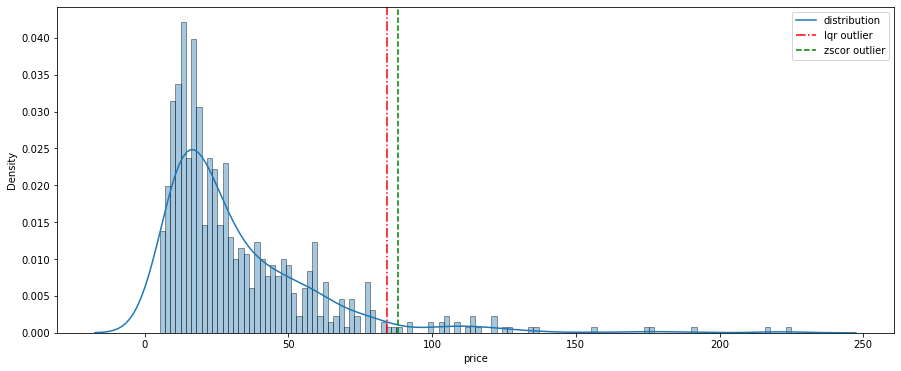

In [58]:
plt.figure(figsize=(15, 6))
sns.distplot(fusion_all['price'], bins = 120, hist_kws = {'edgecolor':'black'})
plt.axvline(x=upper_bound, color='red', ls="dashdot")
plt.axvline(x=88, color='green', ls="--")
plt.legend(labels=["distribution","Iqr outlier","zscor outlier"])

-> we see that the distribution is an asymmetric Gaussian law

-> we can see graphically the difference between the two methods(zscore, interquartile)

->  we will calculate the skewness coeffecient of price distribution

In [59]:
fusion_all['price'].skew()

2.5783867733747523

##### boxplot of product price 

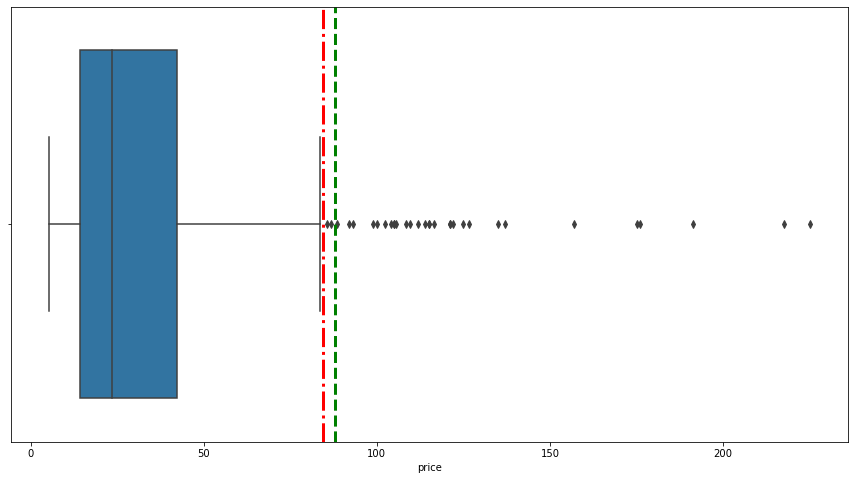

In [60]:
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'price',  data = fusion_all)
plt.axvline(x=upper_bound, color='red', ls="dashdot", lw = 3)
plt.axvline(x=88, color='green', ls="--", lw = 3)

-> The interquartil method (red line) is closest to what the boxplot appears as outlier than zscore method (green line)

-> the boxplot confirms the previous results

##### representation of prices compared to total_sales on a scatter

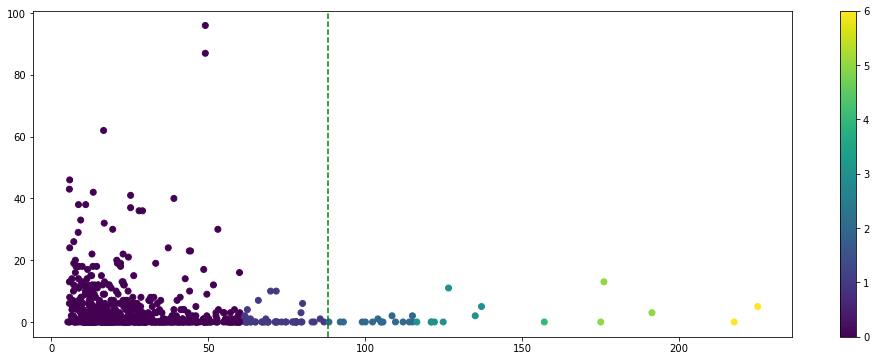

In [61]:
x = fusion_all['price']
y = fusion_all['total_sales']
z = fusion_all['zscore']
z = z.astype(int)

plt.figure(figsize=(17, 6))
plt.scatter(x, y, c=z)
plt.axvline(x=88, color='green', ls="--")
plt.colorbar(ticks=list(z.unique()))
plt.show()

-> colorbar represents the prices against their zscore

-> the green line represents products whose zscore is greater than 2 standard deviation

###### representation of the price distribution of sold and unsold product

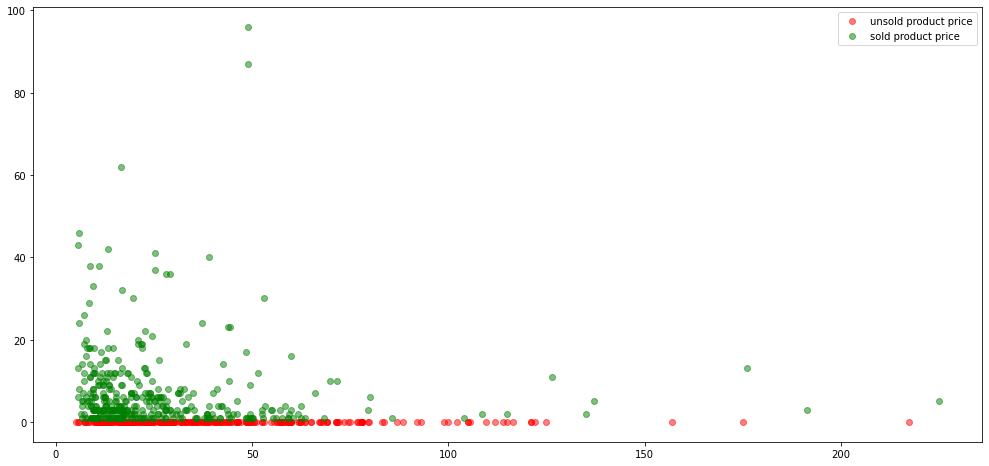

In [62]:
x = fusion_all['price']
y = fusion_all['total_sales']
z=fusion_all['total_sales']
plt.figure(figsize=(17, 8))
plt.scatter(x[z ==0], y[z==0],c = 'red', alpha=0.5)
plt.scatter(x[z >0], y[z >0],c = 'green', alpha=0.5)
plt.legend(labels=["unsold product price","sold product price"])

-> we see that there are products not sold at all prices, so there is not specifically a price range that is not sold

### 6.Test the kmeans clustering algorithm

###### data standardization
-> select the input dataset

-> we scale the dataset so that the features have a mean of 0 and a standard deviation of 1

In [63]:
col= ['price', 'total_sales', 'stock_quantity']
data = fusion_all[col]
scaler = StandardScaler()
fusion_scaled = scaler.fit_transform(data)

-> Instantiate the KMeansclass with the following arguments:

n_clusters = 7: The number of clusters to form as well as the number of centroids to generate.

n_init = 10: Number of times the k-means algorithm will be executed with different centroid seeds

init = 'k-means ++' selects the initial cluster centers intelligently to speed up convergence

In [64]:
kmeans = KMeans(n_clusters=7, n_init=10, init='k-means++').fit(fusion_scaled)

In [65]:
# Here's a look at the first five predicted labels:
kmeans.labels_[:5]

array([0, 5, 0, 5, 6])

In [66]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[-0.43101016, -0.25591889, -0.24509305],
       [-0.39029108,  6.20897007,  1.70754783],
       [ 3.54653541, -0.27886254, -0.4284244 ],
       [-0.62504631,  0.18479485,  1.10790155],
       [-0.82674882,  1.00505741,  4.68407808],
       [ 0.84809359, -0.35553523, -0.44516625],
       [-0.34651046,  1.96069835, -0.29868044]])

-> Predict the closest cluster to which each sample belongs in fusion_scaled.

In [67]:
pred = kmeans.predict(fusion_scaled)

###### 3D graphical representation of cluster groups 

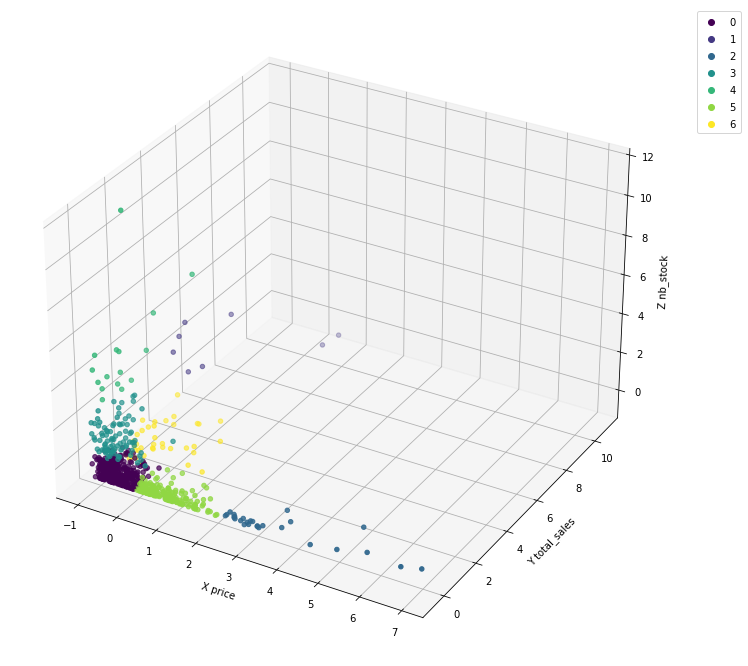

In [68]:
fig = plt.figure(figsize=(27, 12))
ax = fig.add_subplot(111, projection='3d')
sc=ax.scatter(fusion_scaled[:,0], fusion_scaled[:,1], fusion_scaled[:,2], c=pred )
ax.set_xlabel('X price')
ax.set_ylabel('Y total_sales')
ax.set_zlabel('Z nb_stock')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

###### we change the number of clusters and we represent them graphically

In [69]:
kmeans1 = KMeans(n_clusters=3, n_init=10, init='k-means++').fit(fusion_scaled)
pred1 = kmeans1.predict(fusion_scaled)

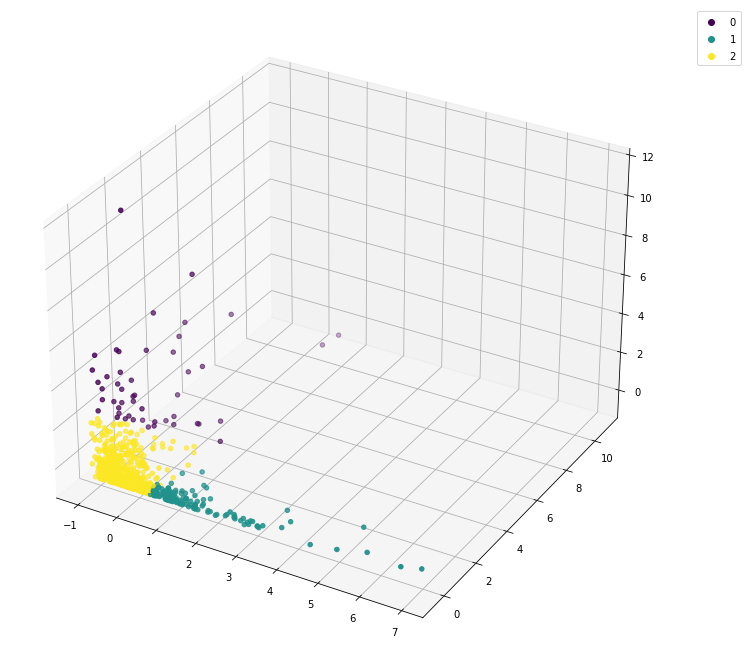

In [70]:
fig = plt.figure(figsize=(27, 12))
ax = fig.add_subplot(111, projection='3d')
sb=ax.scatter(fusion_scaled[:,0], fusion_scaled[:,1], fusion_scaled[:,2], c=pred1)
plt.legend(*sb.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

-> we'll look at two commonly used methods to assess the appropriate number of clusters: "The elbow method" and "The silhouette coefficient", often used as complementary assessment techniques.

###### elbow point
To perform the elbow point method, we run multiple k-means, increment k on each iteration, and save the SSE:

In [71]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++')
    kmeans.fit(fusion_scaled)
    sse.append(kmeans.inertia_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


-> we display the graph of the different values of SSE

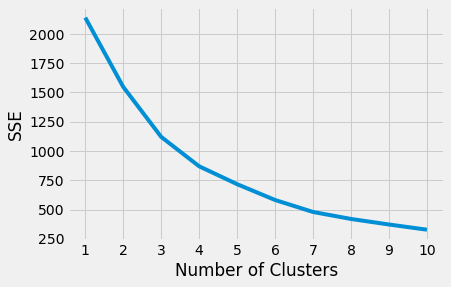

In [72]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

-> Determining the point of the elbow in the SSE curve is not easy so we're going to use a Python package, kneed, to identify the knee point programmatically:

In [73]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

-> we display the graph of the different values of SSE with the elbow that we calculate before

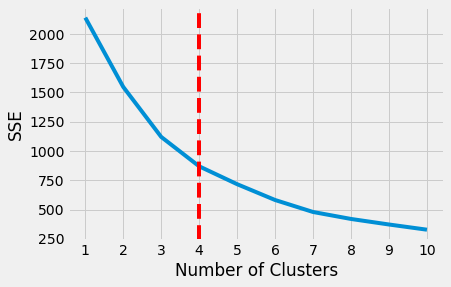

In [74]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.axvline(x=kl.elbow, color='red', ls="--")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

###### silhouette coefficient
-> Loop through knouveau values. This time, instead of calculating SSE, calculate the silhouette coefficient

In [75]:
silhouette_coefficients = []
  
 # Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, n_init=10, init='k-means++' )
    kmeans.fit(fusion_scaled)
    score = silhouette_score(fusion_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

In [76]:
silhouette_coefficients

[0.5818790777493525,
 0.4427465040904908,
 0.46866077647704113,
 0.37679919206618195,
 0.394131751353505,
 0.429282761109722,
 0.427914273732251,
 0.35579147266102024,
 0.354691274198051,
 0.35740004632717065,
 0.3643548961888977,
 0.3475692763939158,
 0.3543150040530592]

-> The plot of the average silhouette scores for each km shows that the best choice for k is 2

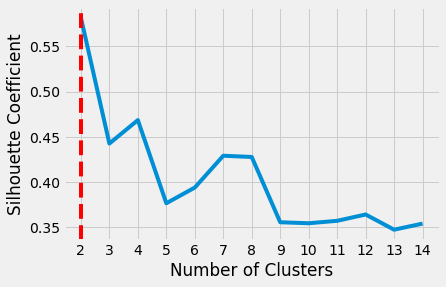

In [77]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.axvline(x=2, color='red', ls="--")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

-> comparison between the silhouette coefficient of a k -means and a DBSCAN algorithm

In [81]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=7)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(fusion_scaled)
dbscan.fit(fusion_scaled)

 # Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(fusion_scaled, kmeans.labels_).round(2)
dbscan_silhouette = silhouette_score(fusion_scaled, dbscan.labels_).round(2)

In [82]:
kmeans_silhouette

0.41

In [83]:
dbscan_silhouette

0.15

### 7.Test the kmeans clustering algorithm

-> we scale the dataset so that the features have a mean of 0 and a standard deviation of 1

In [84]:
scaler.fit(data)
X_scaled = scaler.transform(data)

In [85]:
ACP = PCA(n_components=3)
ACP.fit(X_scaled)
X_ACP = ACP.transform(X_scaled)

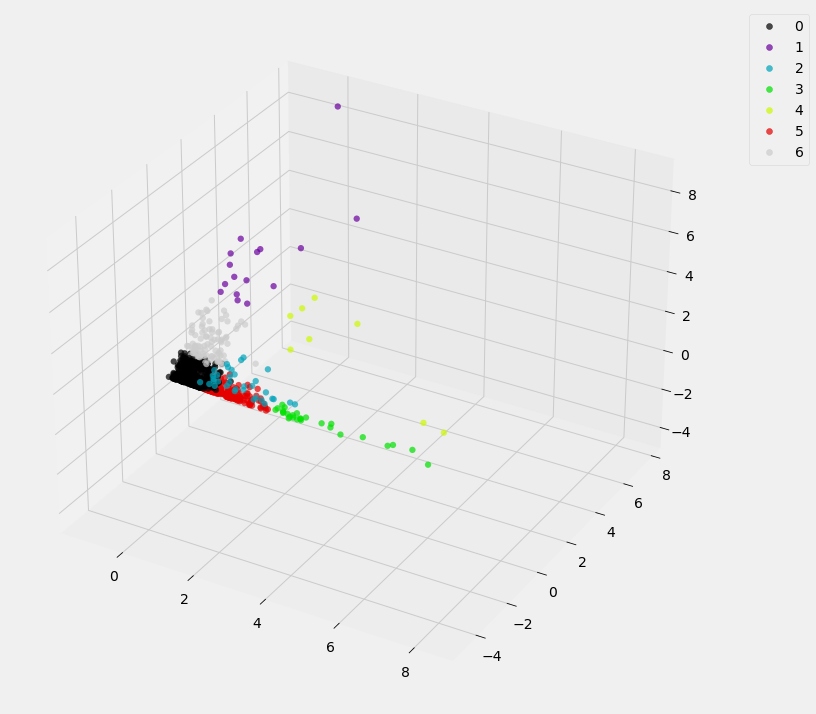

In [86]:
fig = plt.figure(figsize=(27, 12))
ax = fig.add_subplot(111, projection='3d')
sx=ax.scatter( X_ACP[:,1], X_ACP[:,2], X_ACP[:,0], c=kmeans.labels_, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.legend(*sx.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

##### Conclusion 
we notice that the pca brings together clusterers better than Kmeans